<a href="https://colab.research.google.com/github/solee328/LikeLion_EDA/blob/test/EDA_TEST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
import missingno as msno
%matplotlib inline

# 데이터 불러오기


In [1]:
cd drive/MyDrive/data/COVID-19

/content/drive/MyDrive/data/COVID-19


In [108]:
patient_info = pd.read_csv('PatientInfo.csv')
patient_route = pd.read_csv('PatientRoute.csv')

In [109]:
patient_info.head()

,patient_id,global_num,sex,birth_year,age,country,province,city,disease,infection_case,infection_order,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state
0,1000000001,2.0,male,1964.0,50s,Korea,Seoul,Gangseo-gu,NaN,overseas inflow,1.0,NaN,75.0,2020-01-22,2020-01-23,2020-02-05,NaN,released
1,1000000002,5.0,male,1987.0,30s,Korea,Seoul,Jungnang-gu,NaN,overseas inflow,1.0,NaN,31.0,NaN,2020-01-30,2020-03-02,NaN,released
2,1000000003,6.0,male,1964.0,50s,Korea,Seoul,Jongno-gu,NaN,contact with patient,2.0,2.002000e+09,17.0,NaN,2020-01-30,2020-02-19,NaN,released
3,1000000004,7.0,male,1991.0,20s,Korea,Seoul,Mapo-gu,NaN,overseas inflow,1.0,NaN,9.0,2020-01-26,2020-01-30,2020-02-15,NaN,released
4,1000000005,9.0,female,1992.0,20s,Korea,Seoul,Seongbuk-gu,NaN,contact with patient,2.0,1.000000e+09,2.0,NaN,2020-01-31,2020-02-24,NaN,released


In [110]:
patient_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3388 entries, 0 to 3387
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   patient_id          3388 non-null   int64  
 1   global_num          2276 non-null   float64
 2   sex                 3311 non-null   object 
 3   birth_year          2927 non-null   float64
 4   age                 3304 non-null   object 
 5   country             3388 non-null   object 
 6   province            3388 non-null   object 
 7   city                3309 non-null   object 
 8   disease             18 non-null     object 
 9   infection_case      2620 non-null   object 
 10  infection_order     31 non-null     float64
 11  infected_by         822 non-null    float64
 12  contact_number      643 non-null    float64
 13  symptom_onset_date  481 non-null    object 
 14  confirmed_date      3385 non-null   object 
 15  released_date       1327 non-null   object 
 16  deceas

In [111]:
patient_route.head()

,patient_id,global_num,date,province,city,type,latitude,longitude
0,1000000001,2.0,2020-01-22,Gyeonggi-do,Gimpo-si,airport,37.615246,126.715632
1,1000000001,2.0,2020-01-24,Seoul,Jung-gu,hospital,37.567241,127.005659
2,1000000002,5.0,2020-01-25,Seoul,Seongbuk-gu,etc,37.592560,127.017048
3,1000000002,5.0,2020-01-26,Seoul,Seongbuk-gu,store,37.591810,127.016822
4,1000000002,5.0,2020-01-26,Seoul,Seongdong-gu,public_transportation,37.563992,127.029534


# 필요한 데이터 추출
**patientInfo**의 경우 정책(policy) 데이터와 연결시켜야 하는데 이때 사용될 만한 항목은 ```province```와 ```confirmed_date```라 생각합니다.  
정책 적용이 대체로 서울시, 경기도 등 지역 별로 적용되었으므로 ```province``` 항목이 사용되어야 하며, 정책 적용기간 동안의 확진자 추이를 확인하기 위해 ```confirmed_date``` 항목이 사용되어야 합니다.  

patientRoute의 경우 ```type```에서 음식점과 관련된 데이터들만 따로 추출해야 합니다. -> 폐업과 연관

## patientInfo

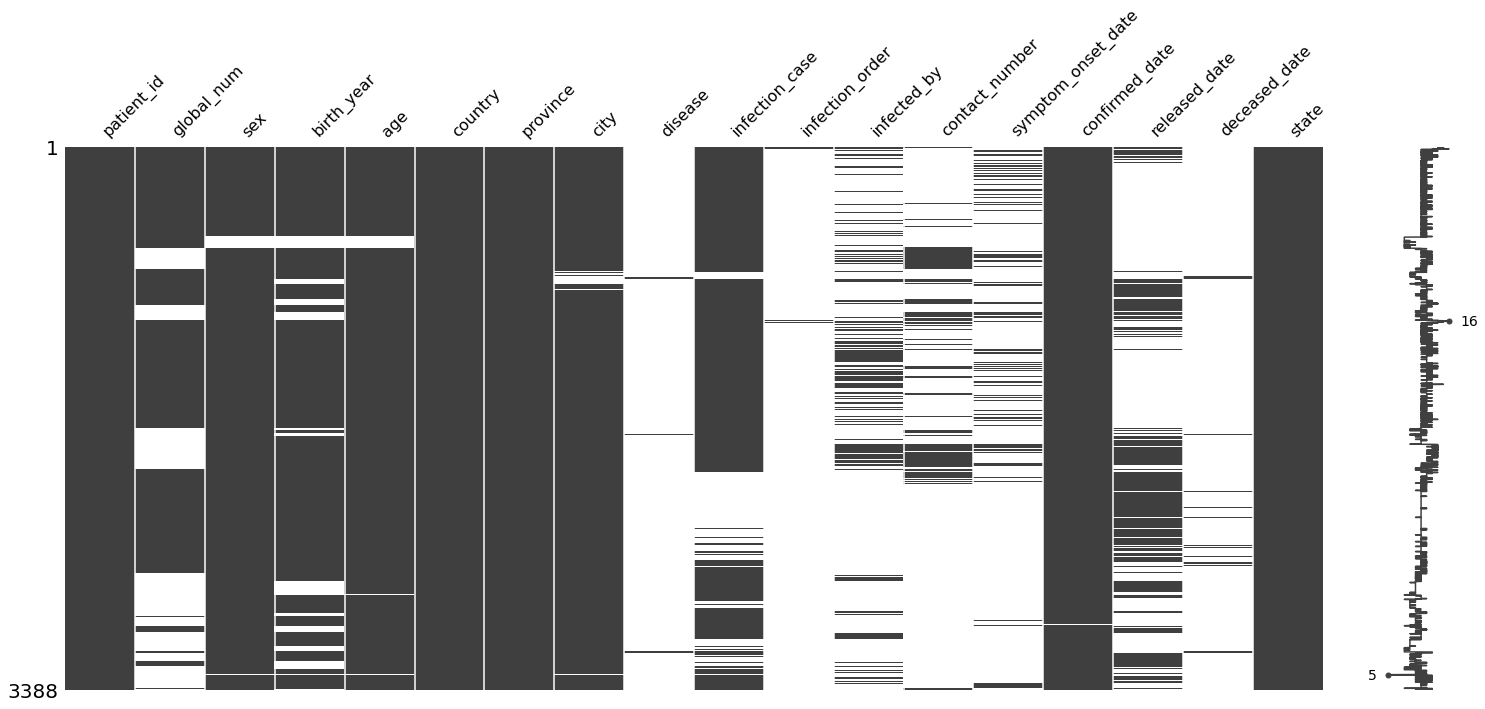

In [112]:
msno.matrix(patient_info)

In [113]:
print('province null count: ', patient_info['province'].isnull().sum())
print('confirmed_date null count', patient_info['confirmed_date'].isnull().sum())

province null count:  0
confirmed_date null count 3


```province```는 결측치가 존재하지 않습니다.  
```confirmed_date```가 없는 데이터는 3388 row 중 3 row로 유추할 수 있는 추가적인 데이터가 없다고 판단되어 해당 row들을 삭제합니다.

In [114]:
patient_need_date = patient_info[patient_info['confirmed_date'].isnull()]
patient_need_date

,patient_id,global_num,sex,birth_year,age,country,province,city,disease,infection_case,infection_order,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state
2980,6011000051,NaN,female,1980.0,40s,Korea,Gyeongsangbuk-do,Andong-si,NaN,etc,NaN,NaN,NaN,NaN,NaN,NaN,NaN,isolated
2981,6011000052,NaN,female,2011.0,0s,Korea,Gyeongsangbuk-do,Andong-si,NaN,etc,NaN,NaN,NaN,NaN,NaN,NaN,NaN,isolated
2982,6011000053,NaN,female,2001.0,10s,Korea,Gyeongsangbuk-do,Andong-si,NaN,etc,NaN,NaN,NaN,2020-04-15,NaN,NaN,NaN,isolated


In [115]:
patient_info.dropna(subset=['confirmed_date'], inplace=True)

In [116]:
patient_info['confirmed_date'].isnull().sum()

0

**patient_info**의 ```confirmed_date```에 NaN값이 있던 행들을 삭제합니다.

In [117]:
type(patient_info['confirmed_date'][0])

str

In [118]:
patient_info['confirmed_date'] = pd.to_datetime(patient_info['confirmed_date'], format='%Y-%m-%d')

In [36]:
type(patient_info['confirmed_date'][0])

pandas._libs.tslibs.timestamps.Timestamp

In [54]:
def extract_by_date(df, date):
  ds = list(map(int, date[0].split('-')))
  de = list(map(int, date[1].split('-')))
  start = pd.Timestamp(ds[0], ds[1], ds[2]).strftime('%Y-%m-%d')
  end = pd.Timestamp(de[0], de[1], de[2]).strftime('%Y-%m-%d')

  mask = (start <= df['confirmed_date']) & (df['confirmed_date']<=end)
  return df.loc[mask]
  

In [72]:
date_1 = extract_by_date(patient_info, ["2020-02-15", "2020-03-10"])

In [73]:
date_1_count = date_1.groupby(['confirmed_date']).size().reset_index(name='counts')

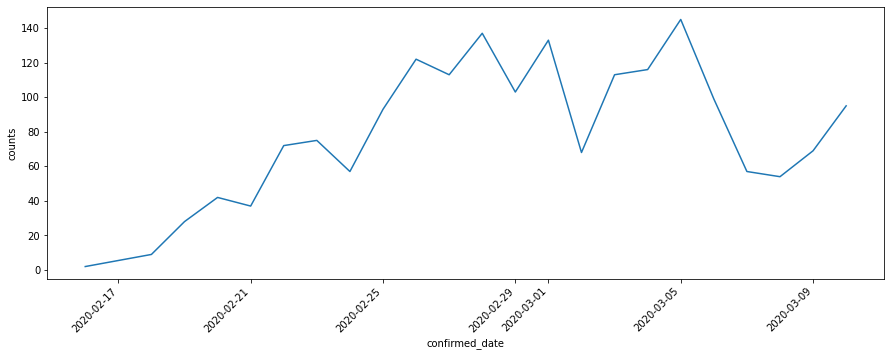

In [98]:
rcParams['figure.figsize'] = 15, 5
plt.xticks(rotation=45, horizontalalignment='right', fontsize='10')
sns.lineplot(x='confirmed_date', y='counts', data=date_1_count)
plt.show()

```confirmed_date```의 type을 str에서 timestamp로 변경해 특정 날짜의 데이터를 추출할 수 있는 ```extract_by_date``` 함수를 만들었습니다.  

예시로 2020-02-15부터 2020-03-10까지의 확진검진을 받은 환자들을 카운트한 lineplot을 그렸습니다.

In [119]:
pd.unique(patient_info['province'])

array(['Seoul', 'Busan', 'Daegu', 'Gwangju', 'Incheon', 'Daejeon',
       'Ulsan', 'Sejong', 'Gyeonggi-do', 'Gangwon-do',
       'Chungcheongbuk-do', 'Chungcheongnam-do', 'Jeollabuk-do',
       'Jeollanam-do', 'Gyeongsangbuk-do', 'Gyeongsangnam-do', 'Jeju-do'],
      dtype=object)

In [129]:
def extract_by_date_province(df, date, province):
    ds = list(map(int, date[0].split('-')))
    de = list(map(int, date[1].split('-')))
    start = pd.Timestamp(ds[0], ds[1], ds[2]).strftime('%Y-%m-%d')
    end = pd.Timestamp(de[0], de[1], de[2]).strftime('%Y-%m-%d')

    mask = (start <= df['confirmed_date']) & (df['confirmed_date']<=end) & (df['province'] == province)
    return df.loc[mask]

In [134]:
date_2 = extract_by_date_province(patient_info, ["2020-02-15", "2020-03-10"], 'Seoul')

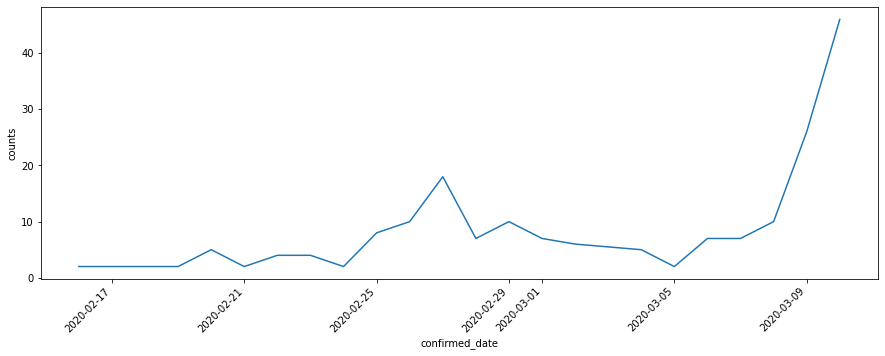

In [135]:
date_2_count = date_2.groupby(['confirmed_date']).size().reset_index(name='counts')
rcParams['figure.figsize'] = 15, 5
plt.xticks(rotation=45, horizontalalignment='right', fontsize='10')
sns.lineplot(x='confirmed_date', y='counts', data=date_2_count)
plt.show()

특정 지역(province)를 추가 파라미터로 설정할 수 있는 ```extract_by_date_province``` 또한 가능합니다.  
예시로 날짜의 범위는 같으나 ```province```로 'Seoul'을 추가한 lineplot을 그려보았습니다.

## patientRoute

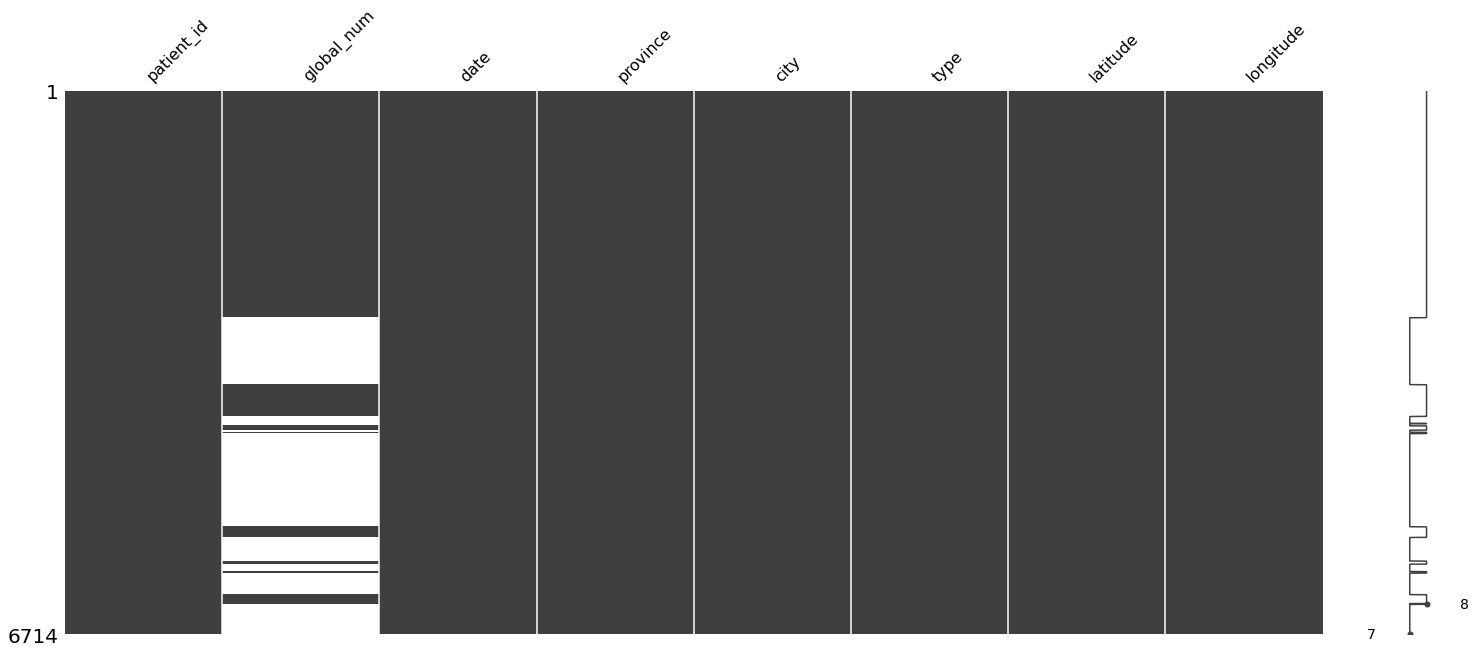

In [104]:
msno.matrix(patient_route)

In [99]:
pd.unique(patient_route['type'])

array(['airport', 'hospital', 'etc', 'store', 'public_transportation',
       'restaurant', 'church', 'beauty_salon', 'pharmacy', 'pc_cafe',
       'bank', 'cafe', 'bakery', 'bar', 'gym', 'school',
       'real_estate_agency', 'karaoke', 'post_office', 'gas_station',
       'lodging', 'academy', 'university', 'administrative_area_level_1'],
      dtype=object)

In [103]:
query_food = "type in ['restaurant', 'bakery', 'bar']"
patient_food = patient_route.query(query_food)

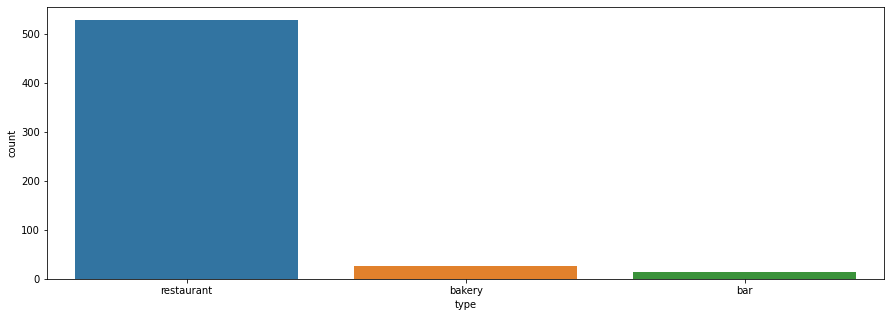

In [106]:
plt.xticks(fontsize='10')
sns.countplot(x="type", data=patient_food)

다행히 ```global_num``` 외 결측치가 있는 항목이 없어 결측치 처리는 따로 하지 않았습니다.  

```type``` 속성 중 ```restaurant```, ```bakery```, ```bar``` 가 음식점 배달과 관련이 있다 판단되어 해당 속성을 가진 데이터만 추출했습니다.  

추출된 속성 별 데이터 수를 나타내보았습니다.

In [146]:
pd.unique(patient_route['province'])

array(['Gyeonggi-do', 'Seoul', 'Incheon', 'Daegu', 'Gyeongsangbuk-do',
       'Daejeon', 'Gyeongsangnam-do', 'Jeollanam-do', 'Jeju-do',
       'Chungcheongbuk-do', 'Jeollabuk-do', 'Busan', 'Gwangju', 'Ulsan',
       'Gangwon-do', 'Chungcheongnam-do'], dtype=object)

In [151]:
query_food = "(type in ['restaurant', 'bakery', 'bar']) and (province == 'Gwangju')"
patient_food = patient_route.query(query_food)

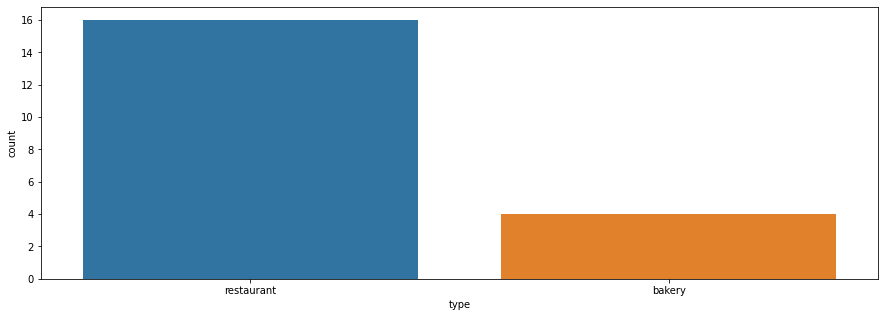

In [152]:
plt.xticks(fontsize='10')
sns.countplot(x="type", data=patient_food)

# 가설


## 정책 데이터
지역 별 거리두기 등의 정책이 시행됨에 따라 해당 지역의 확진자 수가 줄어듬을 볼 수 있다면 거리두기 정책은 효과적이였다 할 수 있다.
- 지역 별 거리두기 정책 시행 시기 확인

## 폐업 데이터
음식점 폐업 비율이 늘어난 지역 및 기간에 대해서 해당 지역의 확진자 수가 늘었거나 확진자들의 음식점 방문이 빈번하게 나타난다면 해당 지역은 코로나 확진자로 인한 폐업일 가능성이 있다.
- 지역/ 기간 별 음식점 폐업 확인

## 모빌리티 데이터
공원, 직장, 대중교통의 유동인구 수는 줄었으나 식료품, 소매점의 유동인구 수가 늘어난 날짜에 대해  
해당 날짜 앞 날들에서 확진자 수가 늘어났다면 코로나로 인한 배달 증가일 가능성이 있다
- 배달 데이터에서 위 조건을 만족하는 기간들 확인